In [1]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits

from astropy.wcs import WCS
from astroquery.jplhorizons import Horizons
from astropy.time import Time
from datetime import timedelta
from astropy.coordinates import SkyCoord
from photutils.centroids import centroid_com, centroid_sources

from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils import aperture_photometry

In [2]:
def error_array(image, gain, readnoise):
	bkg_array = image*0.0 + np.sqrt(image * gain + readnoise**2)
	return bkg_array/gain

def maskerror(img):
	mask = np.zeros(img.shape, dtype=bool)
	idx = np.where(img < 0)

	for j in range(len(idx[0])):
		mask[idx[0][j], idx[1][j]] = True

	img = np.where(img>0, img, 0)
	err_array = np.zeros(img.shape) + np.sqrt(img * gain + readnoise**2)

	err_array = np.where(err_array > readnoise, err_array, 0.)
	err_pixels = err_array / gain
	return err_pixels

In [3]:
gain = 1.67 #e/adu
readnoise = 2.6 #adu
readnoise_e = readnoise * gain

In [4]:
# grab all the filters and make a boolean list
nights = ['22','23','24','25']

filters = []
times = []

rframes = []
gframes = []

night22 = []
night23 = []
night24 = []
night25 = []

i = 0

for night in nights:
    fitses = []

    for name in sorted(glob.glob(f'/Users/josephmurtagh/Documents/INTReducedData/202211{night}/'+'*.fit')):
        fitses.append(name)

    for file in fitses:
        with fits.open(file) as hdu:
            filt = hdu[0].header['WFFBAND']
            irafname = hdu[0].header['irafname']
            mjd = hdu[0].header['mjd-obs']
            times.append(mjd)

        if i <= 41:
            night22.append(irafname)
        elif 42 <= i <= 104:
            night23.append(irafname)
        elif 105 <= i <= 180:
            night24.append(irafname)
        elif i >= 181:
            night25.append(irafname)


        if filt == 'r':
            filters.append(True)
            rframes.append(irafname)
        else:
            filters.append(False)
            gframes.append(irafname)
        
        i+=1

In [5]:
night22_r_start = '2676'
night22_r_end = '2737'
night23_r_start = '2865'
night23_r_end = '2923'
night24_r_start = '3095'
night24_r_end = '3170'
night25_r_start = '3273'
night25_r_end = '3379'

night22_g_start = '2679'
night22_g_end = '2740'
night23_g_start = '2868'
night23_g_end = '2927'
night24_g_start = '3155'
night24_g_end = '3162'
night25_g_start = '3277'
night25_g_end = '3381'

In [8]:
# get the star coordinates in deg in the initial frame from their rough ds9 pixel coordinates
x = [572, 893, 1195, 1275, 1300, 745, 571, 630, 1532, 919]
y = [762, 1255, 219, 480, 788, 1571, 1580, 348, 241, 399]
d = {'x':x,'y':y}
old_df = pd.DataFrame(d)

with fits.open(fitses[0]) as hdu:
    img = hdu[0].data
    irafname = hdu[0].header['irafname']
    wcs = WCS(hdu[0].header)

df = pd.DataFrame(data=np.genfromtxt(f'/Users/josephmurtagh/Documents/INTReducedData/202211{night}/sextractor positions/new_position_{irafname}.cat'), columns=['mag','flux','x','y','fwhm'])
sx = []
sy = []

for pair in old_df.itertuples(index=False, name=None):
    x = pair[0]
    y = pair[1]
    
    distances = []

    for row in df.itertuples(index=False, name=None):
        distances.append(np.sqrt( (x - row[2])**2 + (y - row[3])**2 ))

    distances = [abs(d) for d in distances]
    idx = np.where(distances == np.min(distances))
    sx.append(df.iloc[idx]['x'].values[0])
    sy.append(df.iloc[idx]['y'].values[0])

wx, wy = wcs.wcs_pix2world(sx, sy, 1)
coords = SkyCoord(ra=wx, dec=wy, frame='icrs', unit='deg')

Aperture Photometry on Stars

In [12]:
# choose band to do photometry in
band = gframes

In [27]:
# now perform aperture photometry on stars using above aperture
nights = ['22','23','24','25']

magsdf = pd.DataFrame()
mags_errsdf = pd.DataFrame()
uttimes = pd.Series(dtype='string')

for night in nights:
	fitses = []

	for name in sorted(glob.glob(f'/Users/josephmurtagh/Documents/INTReducedData/202211{night}/'+'*.fit')):
		fitses.append(name)

	for file in fitses:
		with fits.open(file) as hdu:
			img = hdu[0].data
			hdr = hdu[0].header
			irafname = hdr['irafname']
			exptime = hdr['exptime']
			wcs = WCS(hdr)

		if irafname not in band:
			pass
		else:
			err_pixels = maskerror(img)
			uttimes[irafname] = hdr['UT']

			x, y = wcs.world_to_pixel(coords)
			xcent, ycent = centroid_sources(img, x, y, box_size=5, centroid_func=centroid_com)
			d = {'x':xcent, 'y':ycent}
			wdf = pd.DataFrame(d)

			mags = []
			magerrs = []
			
			for n, p in enumerate(wdf.itertuples(index=False, name=None)):
				fwhm = 7.5 / 0.33
				aps = [fwhm]
				sky_aps = [(2 * fwhm)+1, (4 * fwhm)+1]

				apertures = [CircularAperture(p, r=r) for r in aps]
				annulus = CircularAnnulus(p, r_in=sky_aps[0], r_out=sky_aps[1])
				annulus_masks = annulus.to_mask(method='center')

				bkg_median = []

				annulus_data = annulus_masks.multiply(img)
				annulus_data_1d = annulus_data[annulus_masks.data > 0]
				_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
				bkg_median.append(median_sigclip)
				bkg_median = np.array(bkg_median)

				phot = aperture_photometry(img, apertures, error=err_pixels)
				phot['annulus_median'] = bkg_median

				bkg = phot['annulus_median'] * apertures[0].area
				phot['aper_sum_bkgsub_0'] = phot['aperture_sum_0'] - bkg

				phot['inst_mag_0'] = -2.5 * np.log10(phot['aper_sum_bkgsub_0'] / exptime)
				phot['inst_mag_err_0'] = 1.086 * phot['aperture_sum_err_0'] / phot['aper_sum_bkgsub_0']

				mags.append(phot['inst_mag_0'][0])
				magerrs.append(phot['inst_mag_err_0'][0])

			magsdf[irafname] = mags
			mags_errsdf[irafname] = magerrs


the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-11-22        ' to '2022-11-22T00:00:00.0''. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-11-22        ' to '2022-11-22T00:00:00.0''. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-11-22        ' to '2022-11-22T00:00:00.0''. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS k

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

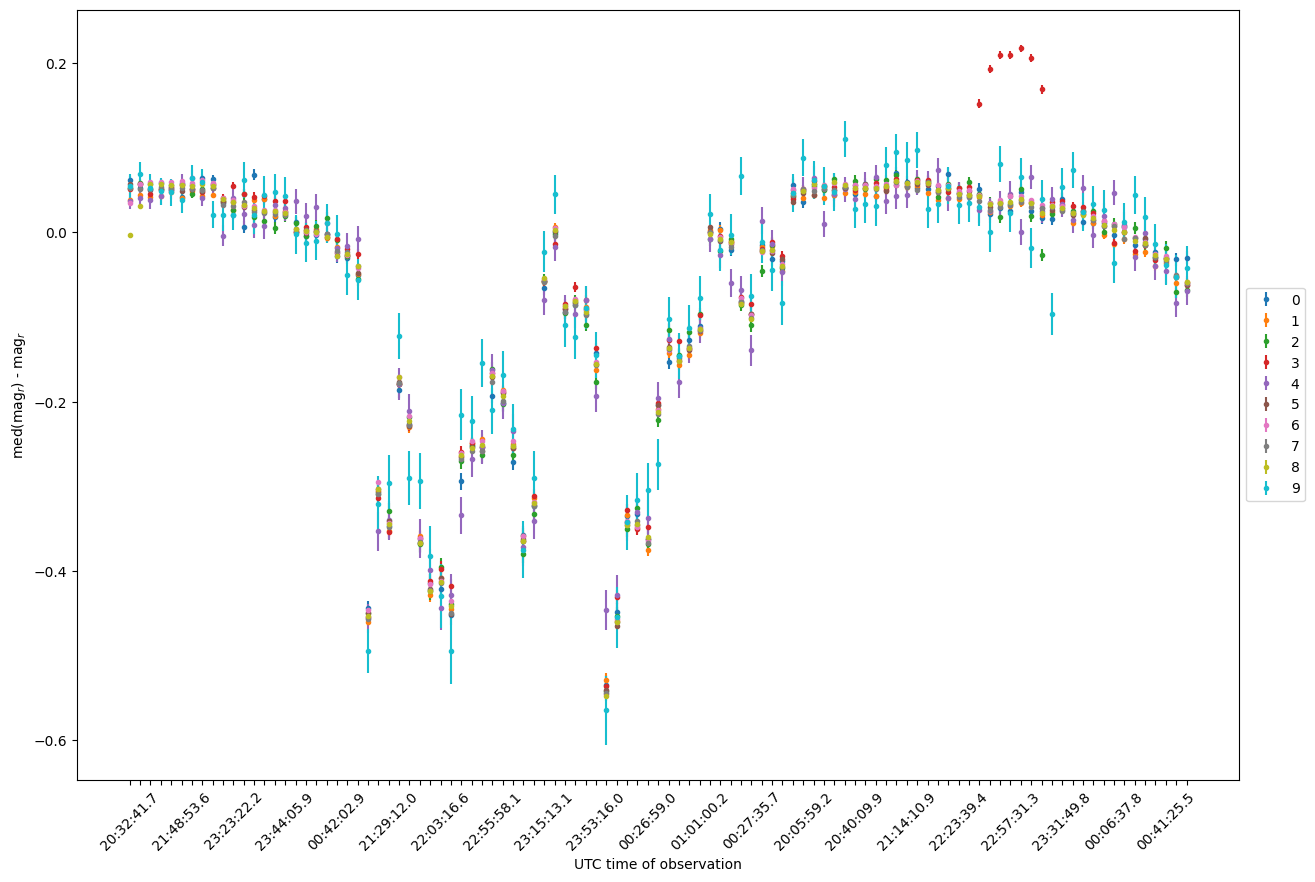

In [31]:
# are the stars variable?
fig, ax = plt.subplots(figsize=(15,10))


offset = False

if offset: 
    offset = 1.0
    for n in range(10):
        datarow = magsdf.loc[n]
        median = np.median(datarow)
        errorrow = mags_errsdf.loc[n]
        ax.errorbar(uttimes, (median-datarow)+offset*n, yerr=errorrow, fmt='.', label=n)
else:
    for n in range(10):
        datarow = magsdf.loc[n]
        median = np.median(datarow)
        errorrow = mags_errsdf.loc[n]
        ax.errorbar(uttimes, (median-datarow), yerr=errorrow, fmt='.', label=n)

ax.set_ylabel(r'med(mag$_r$) - mag$_r$')
ax.set_xlabel('UTC time of observation')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params('x', labelrotation=45)
n = 5  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

/var/folders/nz/q8xlz6ps0y9gljy6tjhp9xh00000gp/T/ipykernel_2890/141246384.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usefulmags = usefulmags.append(magsdf.loc[i]-np.median(magsdf.loc[i]))
/var/folders/nz/q8xlz6ps0y9gljy6tjhp9xh00000gp/T/ipykernel_2890/141246384.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usefulmags = usefulmags.append(magsdf.loc[i]-np.median(magsdf.loc[i]))
/var/folders/nz/q8xlz6ps0y9gljy6tjhp9xh00000gp/T/ipykernel_2890/141246384.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  usefulmags = usefulmags.append(magsdf.loc[i]-np.median(magsdf.loc[i]))
/var/folders/nz/q8xlz6ps0y9gljy6tjhp9xh00000gp/T/ipykernel_2890/141246384.py:4: FutureWarning: The frame.append method is deprecated and will 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

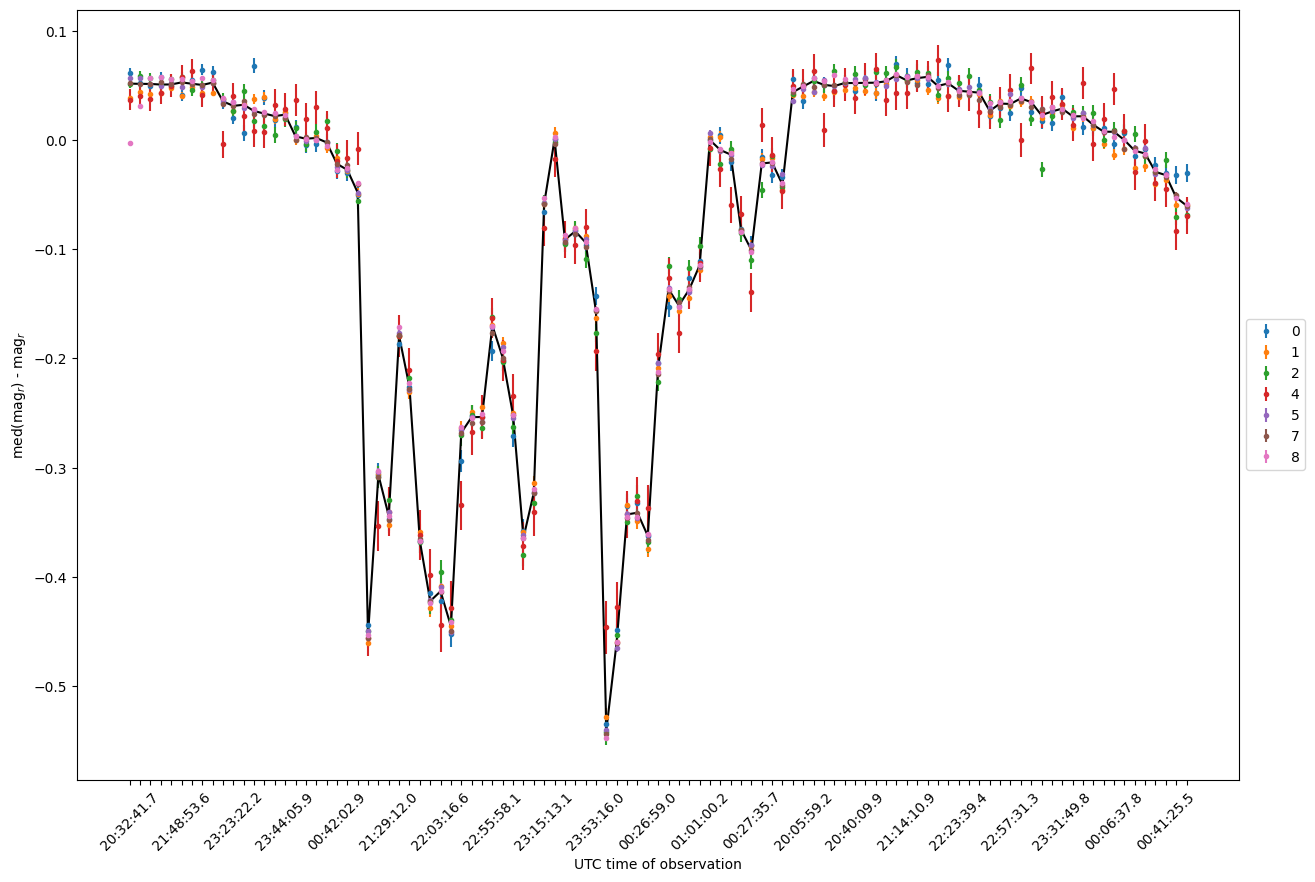

In [33]:
# take useful stars from above and calculate correction shift
stars = [0, 1, 2, 4, 5, 7, 8]
usefulmags = pd.DataFrame()
for i in stars:
    usefulmags = usefulmags.append(magsdf.loc[i]-np.median(magsdf.loc[i]))

correctionfactor = []

for column in usefulmags:
    data = usefulmags[column]
    _, sigmed, _ = sigma_clipped_stats(data)
    correctionfactor.append(sigmed)

fig, ax = plt.subplots(figsize=(15,10))

for n in stars:
        datarow = magsdf.loc[n]
        median = np.median(datarow)
        errorrow = mags_errsdf.loc[n]
        ax.errorbar(uttimes, (median-datarow), yerr=errorrow, fmt='.', label=n)

correctionfactor = -1 * np.asarray(correctionfactor)
ax.plot(correctionfactor, color='k')

ax.set_ylabel(r'med(mag$_r$) - mag$_r$')
ax.set_xlabel('UTC time of observation')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.tick_params('x', labelrotation=45)
n = 5  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

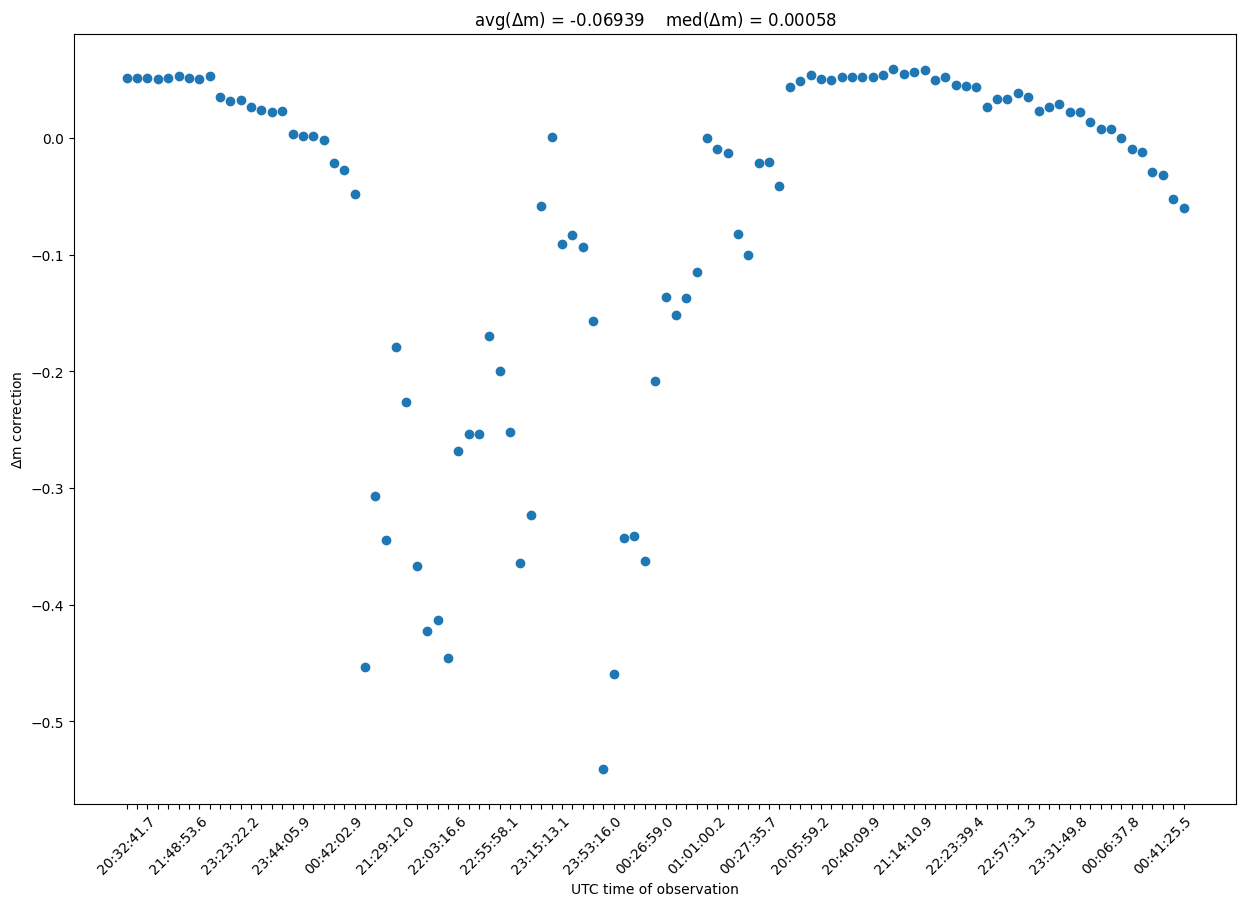

In [36]:
# look at correction shifts
fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(uttimes, correctionfactor)
ax.set_ylabel(r'$\Delta$m correction')
ax.set_xlabel('UTC time of observation')
ax.set_title(f'avg($\Delta$m) = {np.mean(correctionfactor):.5f}    med($\Delta$m) = {np.median(correctionfactor):.5f}')

ax.tick_params('x', labelrotation=45)
n = 5  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

Aperture Photometry on 2015 RR245

In [176]:
band = rframes

if band == rframes:
    filt = 'r'
    night22_start = '2676'
    night22_end = '2737'
    night23_start = '2865'
    night23_end = '2923'
    night24_start = '3095'
    night24_end = '3170'
    night25_start = '3273'
    night25_end = '3379'
elif band == gframes:
    filt = 'g'
    night22_start = '2679'
    night22_end = '2740'
    night23_start = '2868'
    night23_end = '2927'
    night24_start = '3155'
    night24_end = '3162'
    night25_start = '3277'
    night25_end = '3381'

In [177]:
# perform aperture photometry on 2015 rr245 (using star aperture?) - in R
nights = ['22', '23', '24', '25']
magsdf = pd.DataFrame()
mags_errsdf = pd.DataFrame()
times = []
uttimes = pd.Series(dtype='string')
mjdtimes = pd.Series()

for night in nights:
	fitses = []

	for name in sorted(glob.glob(f'/Users/josephmurtagh/Documents/INTReducedData/202211{night}/'+'*.fit')):
		fitses.append(name)

	for file in fitses:
		with fits.open(file) as hdu:
			img = hdu[0].data
			irafname = hdu[0].header['irafname']
			exptime = hdu[0].header['exptime']
			hdr = hdu[0].header
			wcs = WCS(hdu[0].header)

		if irafname not in band:
			pass
		else:
			err_pixels = maskerror(img)

			times.append(hdr['MJD-OBS'])
			mjdtimes[irafname] = hdr['MJD-OBS']
			uttimes[irafname] = hdr['UT']
			dtime = Time(f'{hdr["MJD-OBS"]}', format='mjd')
			dtime.format = 'iso'
			dtime2 = dtime + timedelta(days=1)

			obj = Horizons(id='2015 RR245', location='Z18', epochs={'start':dtime.iso, 'stop':dtime2.iso, 'step':'1d'})
			eph = obj.ephemerides(quantities='1')
			coords = SkyCoord(ra=eph['RA'][0], dec=eph['DEC'][0], frame='icrs', unit='deg')
			x, y = wcs.world_to_pixel(coords)

			xcent, ycent = centroid_sources(img, x, y, box_size=5, centroid_func=centroid_com)
			p = (xcent[0], ycent[0])

			mags = []
			magerrs = []
			
			fwhm = 5.5 / 0.33
			aps = [fwhm]
			sky_aps = [(2 * fwhm)+1, (4 * fwhm)+1]

			apertures = [CircularAperture(p, r=r) for r in aps]
			annulus = CircularAnnulus(p, r_in=sky_aps[0], r_out=sky_aps[1])
			annulus_masks = annulus.to_mask(method='center')

			bkg_median = []

			annulus_data = annulus_masks.multiply(img)
			annulus_data_1d = annulus_data[annulus_masks.data > 0]
			_, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
			bkg_median.append(median_sigclip)
			bkg_median = np.array(bkg_median)

			phot = aperture_photometry(img, apertures, error=err_pixels)
			phot['annulus_median'] = bkg_median

			bkg = phot['annulus_median'] * apertures[0].area
			phot['aper_sum_bkgsub_0'] = phot['aperture_sum_0'] - bkg

			phot['inst_mag_0'] = -2.5 * np.log10(phot['aper_sum_bkgsub_0'] / exptime)
			phot['inst_mag_err_0'] = 1.086 * phot['aperture_sum_err_0'] / phot['aper_sum_bkgsub_0']

			mags.append(phot['inst_mag_0'][0])
			magerrs.append(phot['inst_mag_err_0'][0])

			magsdf[irafname] = mags
			mags_errsdf[irafname] = magerrs

			# fig = plt.figure(figsize=(15,10))
			# plt.imshow(img, cmap='gray', norm=ImageNormalize(img, interval=ZScaleInterval()))
			# apertures[0].plot(color='yellow', lw=2)
			# plt.gca().invert_yaxis()
			# plt.xlim(150, 350)
			# plt.ylim(200, 500)
			# plt.savefig(f'/Users/josephmurtagh/Documents/plots/rudytracking/{irafname}.png')
			# plt.close()

/var/folders/nz/q8xlz6ps0y9gljy6tjhp9xh00000gp/T/ipykernel_2890/2032256633.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  mjdtimes = pd.Series()
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-11-22        ' to '2022-11-22T00:00:00.0''. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '2022-11-22        ' to '2022-11-22T00:00:00.0''. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the RADECSYS keyword is deprecate

In [178]:

mags22 = magsdf.loc[:, f'r164{night22_start}':f'r164{night22_end}']
mags23 = magsdf.loc[:, f'r164{night23_start}':f'r164{night23_end}']
mags24 = magsdf.loc[:, f'r164{night24_start}':f'r164{night24_end}']
mags25 = magsdf.loc[:, f'r164{night25_start}':f'r164{night25_end}']

mags_errs22 = mags_errsdf.loc[:, f'r164{night22_start}':f'r164{night22_end}']
mags_errs23 = mags_errsdf.loc[:, f'r164{night23_start}':f'r164{night23_end}']
mags_errs24 = mags_errsdf.loc[:, f'r164{night24_start}':f'r164{night24_end}']
mags_errs25 = mags_errsdf.loc[:, f'r164{night25_start}':f'r164{night25_end}']

times22 = uttimes.loc[f'r164{night22_start}':f'r164{night22_end}']
times23 = uttimes.loc[f'r164{night23_start}':f'r164{night23_end}']
times24 = uttimes.loc[f'r164{night24_start}':f'r164{night24_end}']
times25 = uttimes.loc[f'r164{night25_start}':f'r164{night25_end}']

In [179]:
# correct to first night median
med22 = np.median(mags22.loc[0])
med23 = np.median(mags23.loc[0])
# med24 = np.median(mags24.loc[:, 'r1643142':]) # remove frames where it passes over star
med24 = np.median(mags24.loc[0])
med25 = np.median(mags25.loc[0])

print(med22)
print(med23)
print(med24)
print(med25)

print()

print(med23 - med22)
print(med24 - med22)
print(med25 - med22)

-3.2604885164674275
-3.7696281054631084
-4.531225312276094
-3.1791146516471676

-0.5091395889956809
-1.2707367958086664
0.08137386482025999


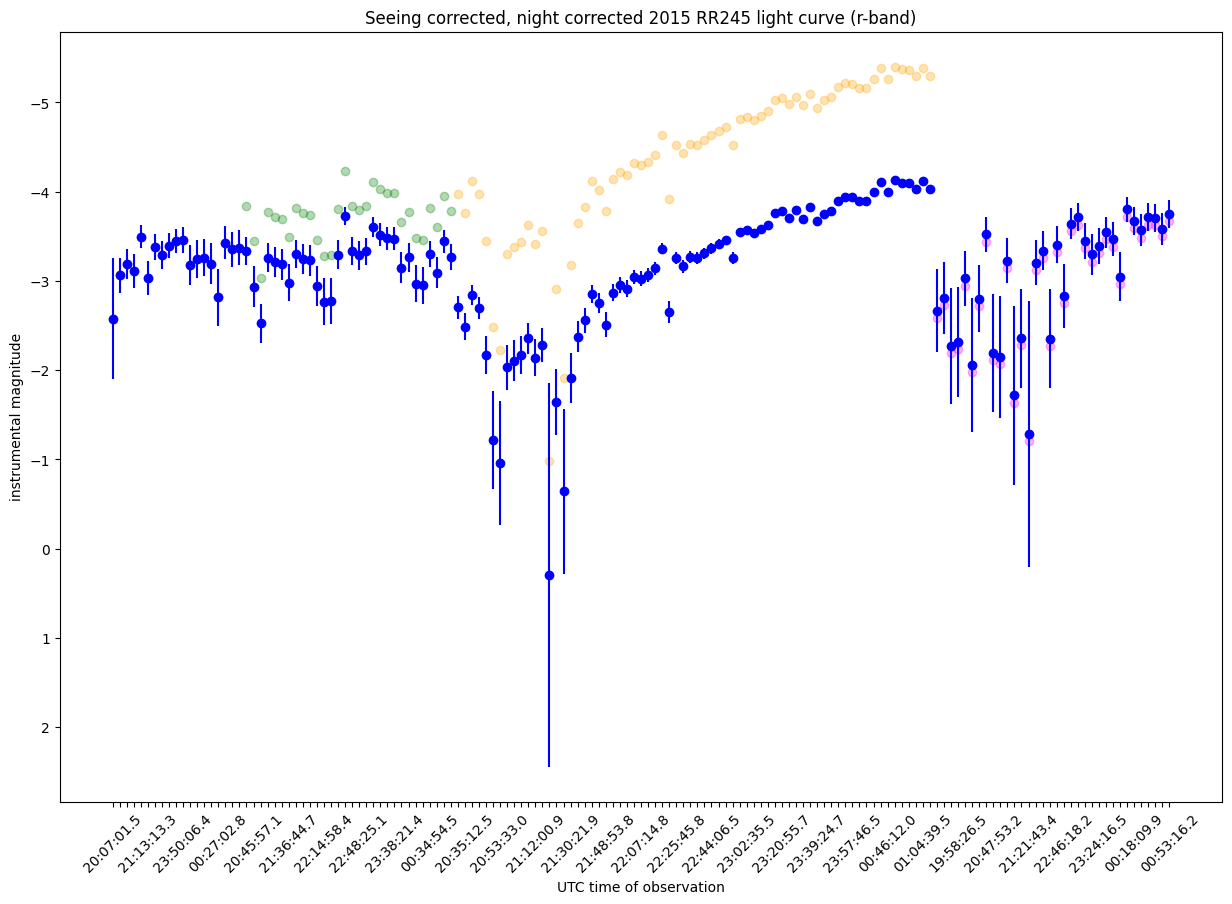

In [180]:
fig, ax = plt.subplots(figsize=(15,10))

t22 = uttimes.loc[f'r164{night22_start}':f'r164{night22_end}']
t23 = uttimes.loc[f'r164{night23_start}':f'r164{night23_end}']
# t24 = uttimes.loc['r1643142':'r1643170'] # select only times whre it isnt over star
t24 = uttimes.loc[f'r164{night24_start}':f'r164{night24_end}']
t25 = uttimes.loc[f'r164{night25_start}':f'r164{night25_end}']

m22 = mjdtimes.loc[f'r164{night22_start}':f'r164{night22_end}']
m23 = mjdtimes.loc[f'r164{night23_start}':f'r164{night23_end}']
# m24 = mjdtimes.loc['r1643142':'r1643170'] # select only times whre it isnt over star
m24 = mjdtimes.loc[f'r164{night24_start}':f'r164{night24_end}']
m25 = mjdtimes.loc[f'r164{night25_start}':f'r164{night25_end}']

# frames = [mags22, mags23 - (med23 - med22), mags24.loc[:, 'r1643142':] - (med24 - med22), mags25 - (med25 - med22)] # select only times whre it isnt over star
# frames = [mags22, mags23 - (med23 - med22), mags25 - (med25 - med22)] # remove night 3 altogether
frames = [mags22, mags23 - (med23 - med22), mags24 - (med24 - med22), mags25 - (med25 - med22)]
shiftedmags = pd.concat(frames, axis=1)
errframes = [mags_errs22, mags_errs23, mags_errs24, mags_errs25]
shiftederrs = pd.concat(errframes, axis=1)


x22 = np.arange(mags22.shape[1])
x23 = x22[-1]+np.arange(mags23.shape[1])
# x24 = x23[-1]+np.arange(mags24.loc[:, 'r1643142':].shape[1]) # select only times whre it isnt over star
x24 = x23[-1]+np.arange(mags24.shape[1])
x25 = x24[-1]+np.arange(mags25.shape[1])

ax.errorbar(t22.values, mags22.values[0], yerr=mags_errs22, linestyle='none', marker='o', color='blue')
ax.errorbar(t23.values, mags23.values[0] - (med23 - med22),  yerr=mags_errs23, linestyle='none', marker='o', color='blue')
# ax.errorbar(t24.values, mags24.loc[:, 'r1643142':].values[0] - (med24 - med22),  yerr=mags_errs24.loc[:, 'r1643142':], linestyle='none', marker='o', color='blue') # select only times whre it isnt over star
ax.errorbar(t24.values, mags24.values[0] - (med24 - med22), yerr=mags_errs24, linestyle='none', marker='o', color='blue')
ax.errorbar(t25.values, mags25.values[0] - (med25 - med22), yerr=mags_errs25, linestyle='none', marker='o', color='blue')

ax.scatter(t22.values, mags22.values[0], alpha=0.3, marker='o', color='red')
ax.scatter(t23.values, mags23.values[0], alpha=0.3, marker='o', color='green')
# ax.scatter(t24.values, mags24.loc[:, 'r1643142':].values[0], alpha=0.3, marker='o', color='orange')
ax.scatter(t24.values, mags24.values[0], alpha=0.3, marker='o', color='orange')
ax.scatter(t25.values, mags25.values[0], alpha=0.3, marker='o', color='magenta')

ax.tick_params('x', labelrotation=45)
n = 5  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

ax.set_ylabel('instrumental magnitude')
ax.set_xlabel('UTC time of observation')
ax.set_title(f'Seeing corrected, night corrected 2015 RR245 light curve ({filt}-band)')

plt.gca().invert_yaxis()

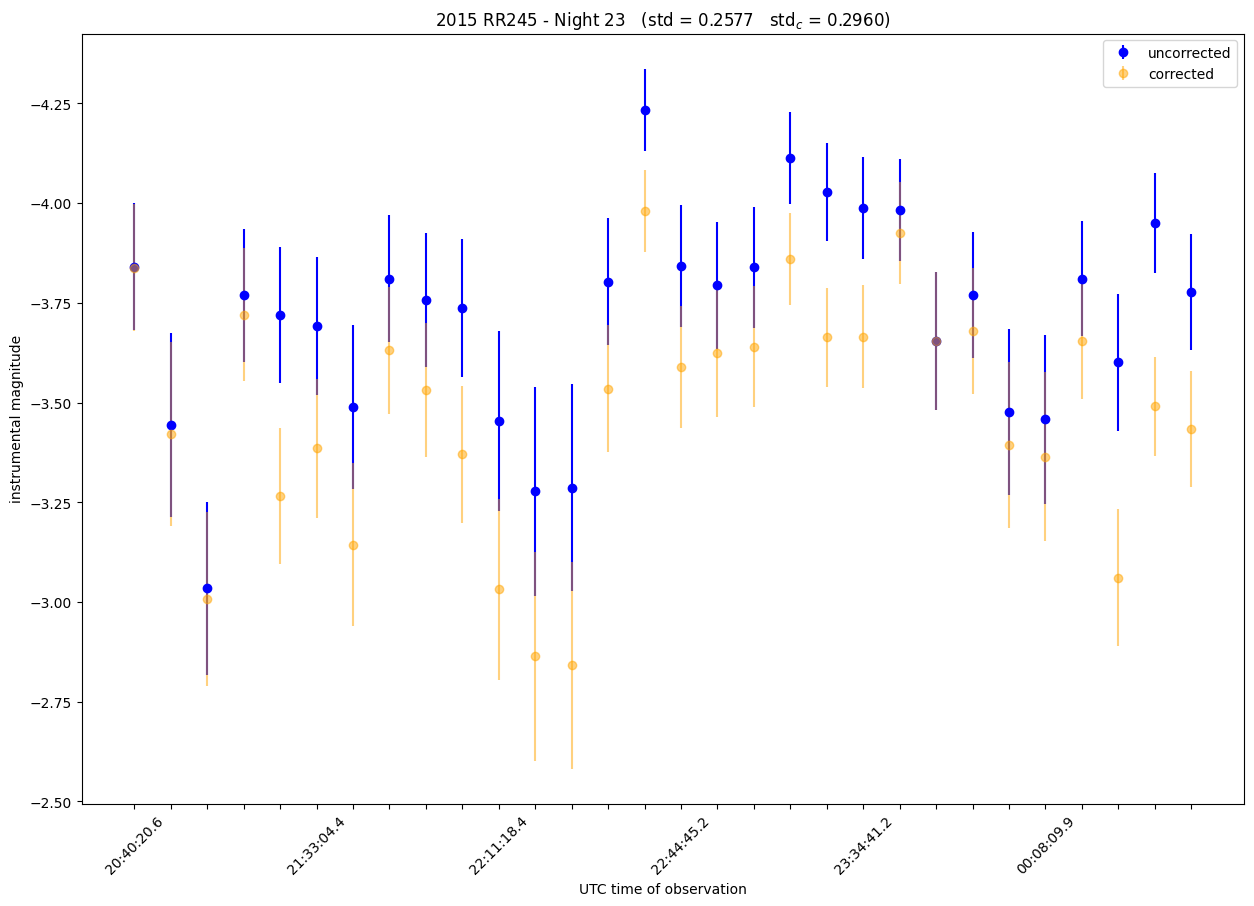

In [183]:
# look at each night
fig, ax = plt.subplots(figsize=(15,10))

night = 23
if night == 22:
    night_start = night22_start
    night_end = night22_end
    t = t22
    i = magsdf.columns.get_loc(f'r164{night22_start}')
elif night == 23:
    night_start = night23_start
    night_end = night23_end
    t = t23
    i = magsdf.columns.get_loc(f'r164{night23_start}')
elif night == 24:
    night_start = night24_start
    night_end = night24_end
    t = t24
    i = magsdf.columns.get_loc(f'r164{night24_start}')
elif night == 25:
    night_start = night25_start
    night_end = night25_end
    t = t25
    i = magsdf.columns.get_loc(f'r164{night25_start}')

m = magsdf.loc[:, f'r164{night_start}':f'r164{night_end}'].values[0]
me = mags_errsdf.loc[:, f'r164{night_start}':f'r164{night_end}'].values[0]
j = i + len(m)

ax.errorbar(t, m, yerr=me, fmt='o', color='blue', label='uncorrected')
ax.errorbar(t, m - correctionfactor[i:j], yerr=me, fmt='o', color='orange', alpha=0.5, label='corrected')
ax.tick_params('x', labelrotation=45)
ax.set_xlabel('UTC time of observation')
ax.set_ylabel('instrumental magnitude')
ax.set_title(fr'2015 RR245 - Night {night}   (std = {np.std(m):.4f}   std$_c$ = {np.std(m - correctionfactor[i:j]):.4f})')
ax.legend()

n = 5  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

plt.gca().invert_yaxis()

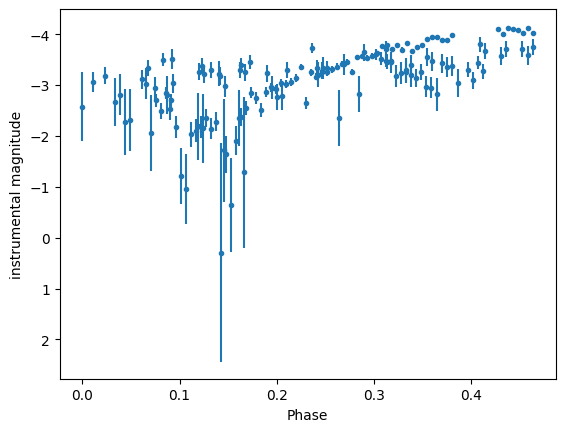

In [182]:
period = 11.878/24
t = np.asarray(mjdtimes.values)
phase = ((t-t[0]) / period) % 1.
plt.errorbar(phase, shiftedmags.loc[0], mags_errsdf.loc[0], fmt='.')
plt.xlabel('Phase')
plt.ylabel('instrumental magnitude')
plt.gca().invert_yaxis()